In [1]:
# Import libraries
from keras import backend  # required for loading model
from keras.models import load_model
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

2024-03-05 00:27:27.820073: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 00:27:27.884840: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 00:27:28.234947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 00:27:28.235072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 00:27:28.295953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# XAI Workflow:
### Concept: 
Based on Ishikawa et al. 2023. The test sample feature vector from the classification/siamese model will be compared with all samples from the training data to identify the most similar samples. These samples will be shown to the User to help build confidence in the classification provided by the model. 

### Steps:
1. Data loading: 
   - load the test samples
   - load the class examples
2. Classification:
   - load the Siamese model
   - pair the test sample with all class examples
   - compute similarity scores
3. Explanation
   - Load the feature extraction model
   - Obtain the feature vectors for the test sample
   - Obtain the feature vectors for the class examples
   - Calculate the distance between the test sample and the class examples
   - Plot similar images with lowest feature vector distance scores 

## Step 1: Data Loading

### Load example classes

In [2]:
# Individual cut-out of trees extracted from reforestree dataset
imdata = xr.open_zarr('../../data/reforestree/processed/foresttree.zarr/')
imdata = imdata  # normalize to 0-1

In [3]:
# The training data is split into a dictionary of samples per class to facilitate ease of comparison 
# Due to memory limitation, currently restricting the samples to 100 for each class in the training data
# NOTE: All the training data needs to be used in an actual run - to do so, please remove the last isel in line 6: .isel(sample=range(100))
classes =  np.unique(imdata.Y.values)
class_data = {}
for class_i in classes:
    class_data[class_i] = imdata.where(imdata.Y.compute()==class_i, drop=True).isel(sample=range(100))

### Load Test Sample

In this case, we will load a sample from the original data-set that was not used for training.

Text(0.5, 1.0, 'True class 1')

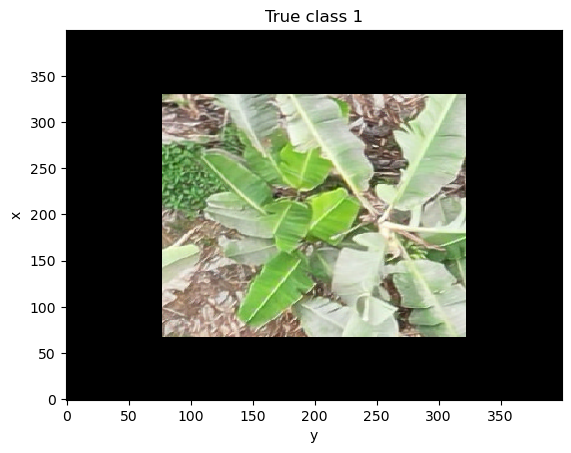

In [4]:
# test_sample = imdata.isel(sample=3005) # Image cut-out of class 2 but polluted with class 1
test_sample = imdata.isel(sample=3007)

# Visualize the test sample
test_sample['X'].astype('int').plot.imshow()
plt.title(f"True class {test_sample['Y'].values.astype('str')}")


## Step 2: Classification

In [5]:
siamese_model = load_model('../optimized_models/siamese_model.h5')
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  393856    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['model[0][0]',         

In [6]:
similarity_scores = {}
list_scores = []
for class_i in classes:
    X_sample_norm = test_sample.expand_dims({'sample': 100})['X'].to_numpy()/255.
    X_class_norm = class_data[class_i]['X'].to_numpy()/255.
    scores = siamese_model.predict([X_sample_norm, X_class_norm], batch_size=32)
    list_scores.append(scores)
    #take average of the scores
    similarity_scores[class_i] = np.mean(scores)

4/4 [==============================] - 2s 324ms/step


In [7]:
similarity_scores

{1: 0.5622251, 2: 0.18397829, 4: 0.27758294}

In [8]:
# Get predicted class
predicted_class = max(similarity_scores, key=similarity_scores.get)
predicted_class

1

## Step 3: Explanation

### Load the feature extraction model

In [9]:
feature_extractor_model = load_model('../optimized_models/feature_extractor_model.h5')
feature_extractor_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 400, 400, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 400, 400, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 100, 100, 64)      256 

### Obtain feature vectors for example classes

In [10]:
class_features = {}
for class_i in classes:
    X_class_norm = class_data[class_i]['X'].to_numpy()/255.
    class_features[class_i] = feature_extractor_model.predict(X_class_norm, batch_size=32)

4/4 [==============================] - 1s 200ms/step


### Obtain test feature vector

In [11]:
X_sample_norm = test_sample.expand_dims({'sample': 1})['X'].to_numpy()/255.
test_feature_vector = feature_extractor_model.predict([X_sample_norm])

1/1 [==============================] - 0s 227ms/step


### Compare test feature vector 
Test feature vector is to be compared with all training samples to identify best match for (analyse best norm option):
   1) same class
   2) other classes

In [12]:
# Calculate cosine, l1, and l2 distances for test sample for every sample in each class of the training data 
cosine_dist = {}
l1_dist = {}
l2_dist = {}
for class_i in classes:
    cosine_dist[class_i] = cosine_distances(class_features[class_i], test_feature_vector)
    l2_dist[class_i] = euclidean_distances(class_features[class_i], test_feature_vector)
    l1_dist[class_i] = manhattan_distances(class_features[class_i], test_feature_vector)

### Method1: obtain best match for each class for each distance metric

In [13]:
best_cosine_match = {}
best_l1_match = {}
best_l2_match = {}
for class_i in classes:
    best_cosine_match[class_i] = np.argmin(cosine_dist[class_i])
    best_l2_match[class_i] = np.argmin(l2_dist[class_i])
    best_l1_match[class_i] = np.argmin(l1_dist[class_i])

### Plot similar images with lowest feature vector distance scores 

#### Cosine plot

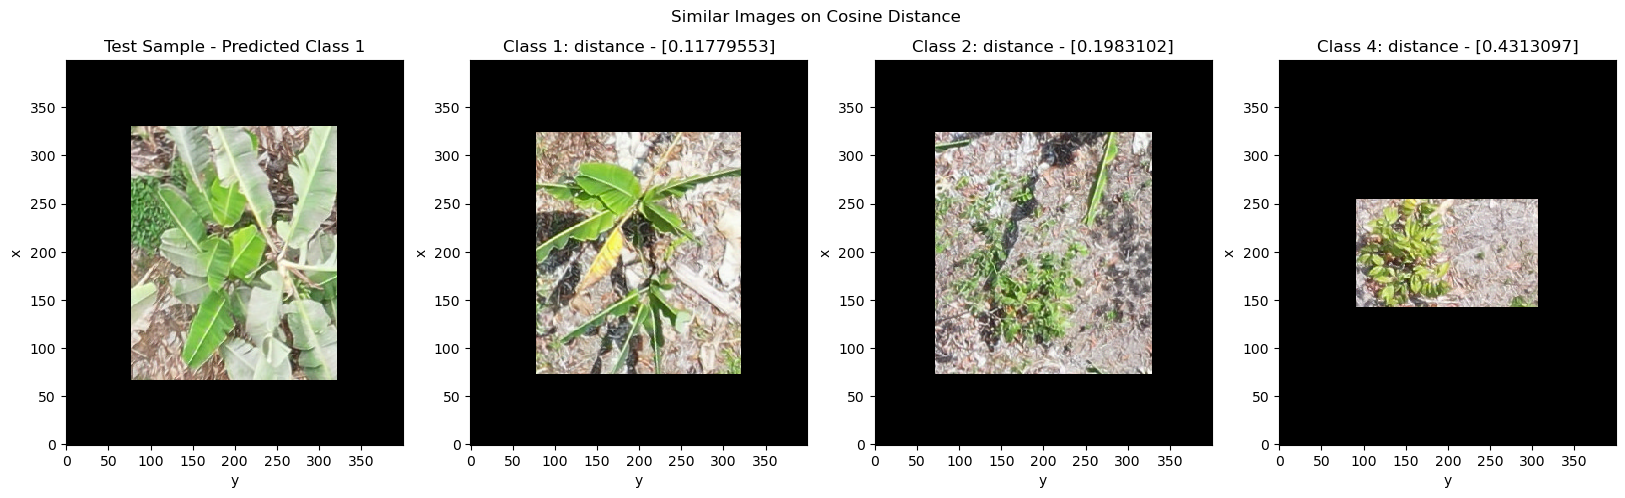

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on Cosine Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {predicted_class}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_cosine_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {cosine_dist[class_i][best_cosine_match[class_i]]}')

#### L1 Plot

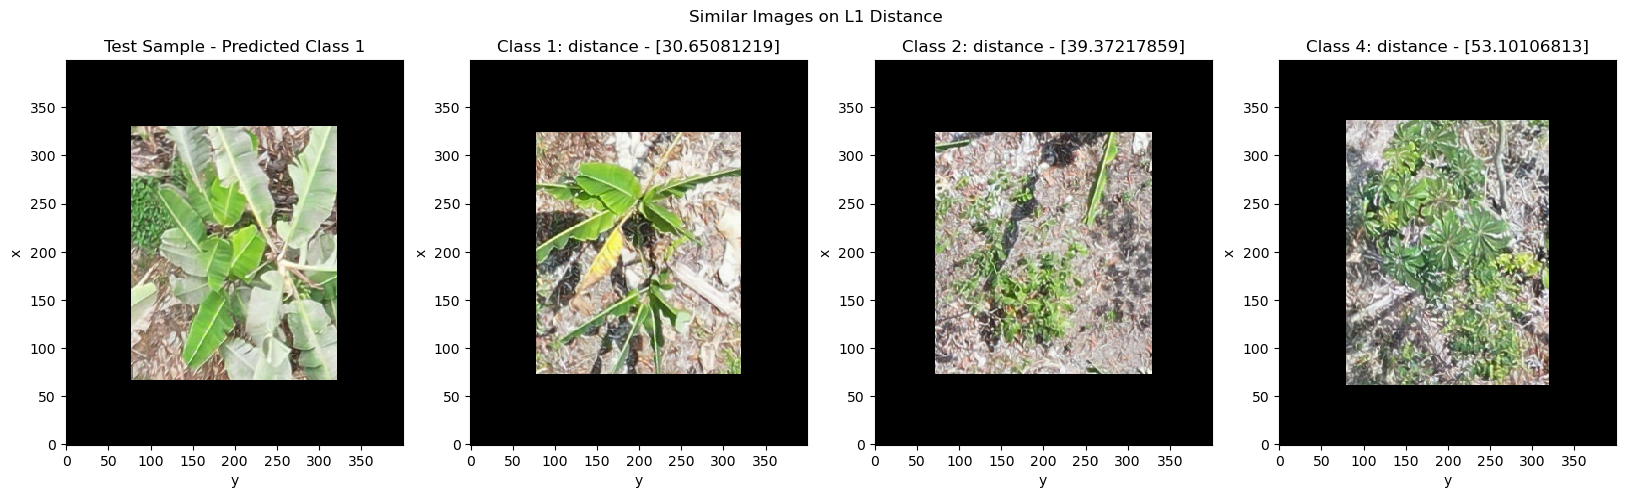

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on L1 Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {predicted_class}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_l1_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {l1_dist[class_i][best_l1_match[class_i]]}')

#### L2 Plot

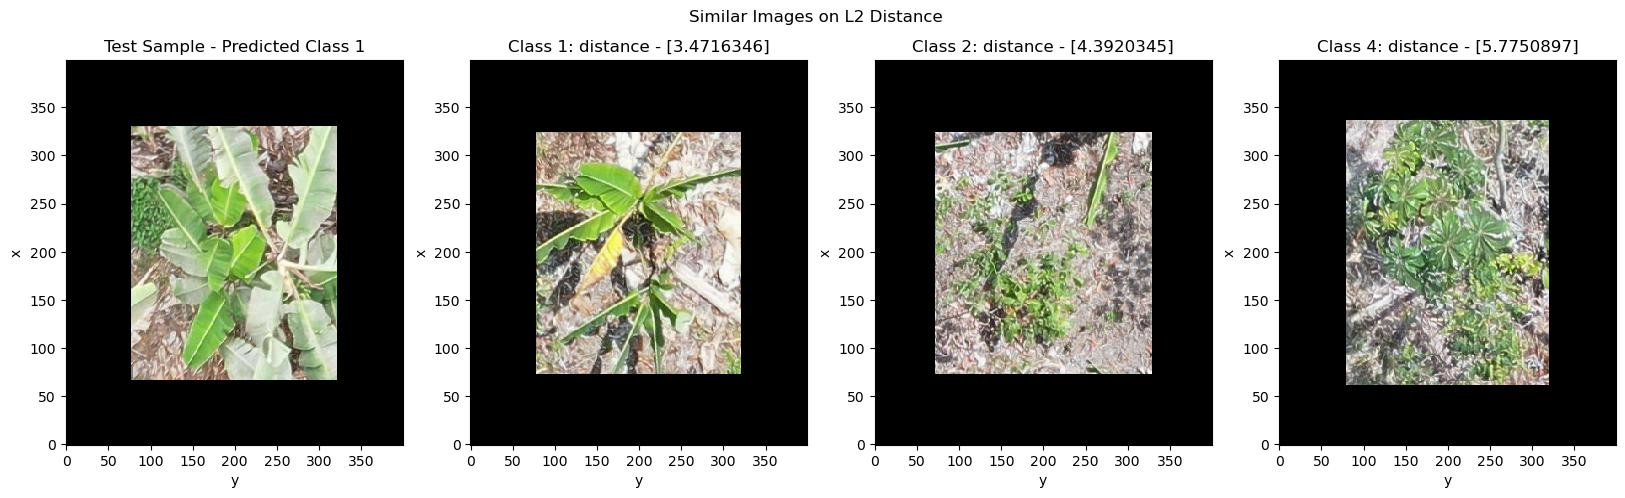

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=len(classes)+1, figsize=(5*(len(classes)+1), 5))
fig.suptitle('Similar Images on L2 Distance')
test_sample.X.astype(int).plot.imshow(ax=axes[0])
axes[0].set_title(f'Test Sample - Predicted Class {predicted_class}')
for class_i, ax in zip(classes,axes[1:]):
    class_data[class_i].X[best_l2_match[class_i]].astype(int).plot.imshow(ax=ax)
    ax.set_title(f'Class {class_i}: distance - {l2_dist[class_i][best_l2_match[class_i]]}')